In [1]:
import os

# Set the environment variable before importing TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Verify Using tf 2.15
import tensorflow as tf
print(tf.__version__)

2.15.0


In [2]:
# Verify the use of GPU
# import tensorflow as tf
print('Visible Devices: ', tf.config.get_visible_devices())
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs available: ", gpus)
else:
    print("No GPUs found")

Visible Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.layers import ReLU, Add, BatchNormalization, Conv2D, Dense, GlobalAveragePooling2D, Input, Activation, Rescaling, MaxPool2D
from tensorflow.keras.models import Sequential
import pathlib
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import decode_predictions

In [5]:
data_dir = 'image_data'
data_dir = pathlib.Path(data_dir)

In [6]:
# Verify the number of images in the folder
print(len(list(data_dir.glob('*/*.jpg'))))

449


In [410]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  label_mode='int',
  validation_split=0.2,
  subset="both",
  seed=42,
  image_size=(224, 224),
  batch_size=32)

Found 449 files belonging to 3 classes.
Using 360 files for training.
Using 89 files for validation.


In [8]:
# Print class names
class_names = train_ds.class_names
print(class_names)

['church', 'mosque', 'temple']


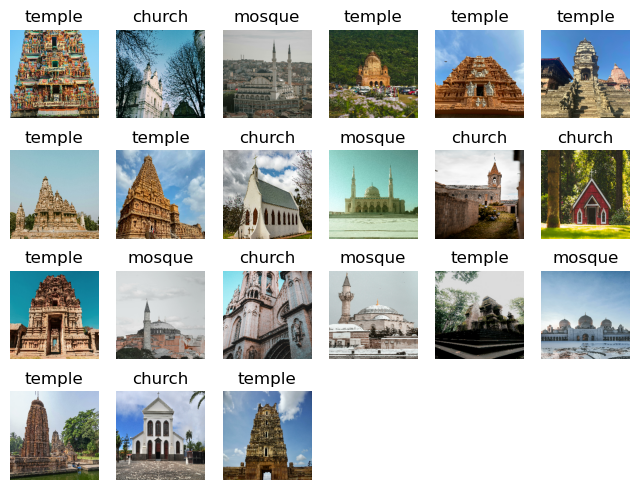

In [9]:
# Visualize train images
plt.figure(figsize=(8, 6))
for images, labels in train_ds.take(1):
  for i in range(21):
    ax = plt.subplot(4, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  break

In [10]:
# Speed up training time (optional)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(300).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
for image_batch, label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [12]:
# Rescale Layer
rescale_input = tf.keras.applications.vgg16.preprocess_input

# Flip and Rotate Layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [103]:
# Using VGG16 to build a reference model

# Input layer
input_shape = (224, 224, 3)
inputs = tf.keras.layers.Input(shape=input_shape)

# Data augmentation Layer
x = data_augmentation(inputs)

# Rescale Layer
x = rescale_input(x)

# VGG16 model without the top layers
vgg16_base = tf.keras.applications.VGG16(include_top=False, input_tensor=x, weights='imagenet')
x = vgg16_base(x, training=False)

# Add custom layers
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [104]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0   

In [107]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgg16_history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=30,
                    callbacks=[callback], verbose=1)

Epoch 1/30
12/12 [==============================] - 18s 1s/step - loss: 3.5581 - accuracy: 0.3417 - val_loss: 1.2590 - val_accuracy: 0.3034
Epoch 2/30
12/12 [==============================] - 17s 1s/step - loss: 1.1992 - accuracy: 0.3306 - val_loss: 1.1419 - val_accuracy: 0.3820
Epoch 3/30
12/12 [==============================] - 17s 1s/step - loss: 1.0914 - accuracy: 0.3917 - val_loss: 1.1030 - val_accuracy: 0.3258
Epoch 4/30
12/12 [==============================] - 17s 1s/step - loss: 1.0661 - accuracy: 0.4194 - val_loss: 1.0415 - val_accuracy: 0.4607
Epoch 5/30
12/12 [==============================] - 17s 1s/step - loss: 1.0274 - accuracy: 0.4528 - val_loss: 1.0244 - val_accuracy: 0.4831
Epoch 6/30
12/12 [==============================] - 17s 1s/step - loss: 0.9933 - accuracy: 0.4917 - val_loss: 1.0522 - val_accuracy: 0.4607
Epoch 7/30
12/12 [==============================] - 17s 1s/step - loss: 1.0398 - accuracy: 0.4778 - val_loss: 1.0200 - val_accuracy: 0.4494
Epoch 8/30
12/12 [==

In [205]:
def plot_acc_loss(model_name, model_history, best_epoch: int, xytext_1: tuple, xytext_2: tuple):
    train_acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    epochs = np.arange(1, len(train_acc) + 1)
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_acc, label='Training Accuracy', ls='-', marker='x')
    plt.plot(epochs, val_acc, label='Validation Accuracy', ls='-', marker='x')
    plt.scatter(best_epoch, train_acc[best_epoch - 1], s=100, marker='x', linewidth=3)
    plt.scatter(best_epoch, val_acc[best_epoch - 1], s=100, marker='x', linewidth=3)
    plt.annotate(text='Epoch {} \nTraining Acc: {} \nValidation Acc: {}'.format(best_epoch, round(train_acc[best_epoch - 1], 2), round(val_acc[best_epoch - 1], 2)),
                 xy=(best_epoch, train_acc[best_epoch - 1]),
                 xytext=xytext_1,
                 textcoords='offset points',
                 bbox=dict(boxstyle='round, pad=0.5', edgecolor='black', facecolor='blue', alpha=0.3)
                )
    plt.legend(loc='lower right')
    plt.xticks(np.arange(1, len(train_acc) + 1, 3))
    plt.ylabel('Accuracy')
    plt.title('{} Training and Validation Accuracy'.format(model_name))
    
    plt.subplot(2, 1, 2)
    plt.plot(epochs, train_loss, label='Training Loss', ls='-', marker='x')
    plt.plot(epochs, val_loss, label='Validation Loss', ls='-', marker='x')
    plt.scatter(best_epoch, train_loss[best_epoch - 1], s=100, marker='x', linewidth=3)
    plt.scatter(best_epoch, val_loss[best_epoch - 1], s=100, marker='x', linewidth=3)
    plt.annotate(text='Epoch {} \nTraining Loss: {} \nValidation Loss: {}'.format(best_epoch, round(train_loss[best_epoch - 1], 2), round(val_loss[best_epoch - 1], 2)),
                 xy=(best_epoch, train_acc[best_epoch - 1]),
                 xytext=xytext_2,
                 textcoords='offset points',
                 bbox=dict(boxstyle='round, pad=0.5', edgecolor='black', facecolor='blue', alpha=0.3)
                )
    plt.legend(loc='upper right')
    plt.xticks(np.arange(1, len(train_acc) + 1, 3))
    plt.ylabel('Cross Entropy')
    plt.ylim()
    plt.title('{} Training and Validation Loss'.format(model_name))
    plt.xlabel('epoch')
    plt.savefig('{} Accuracy and Loss.png'.format(model_name))
    plt.show()

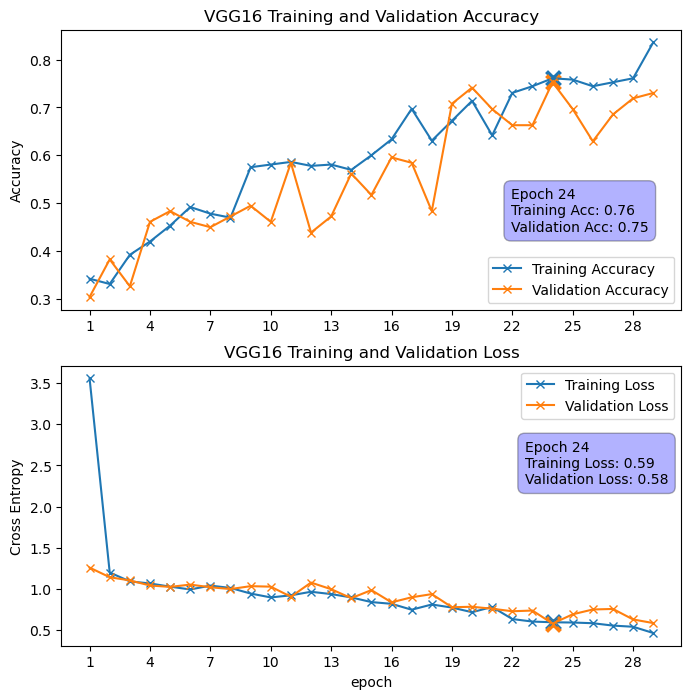

In [119]:
train_acc = vgg16_history.history['accuracy']
val_acc = vgg16_history.history['val_accuracy']
train_loss = vgg16_history.history['loss']
val_loss = vgg16_history.history['val_loss']
epochs = np.arange(1, len(train_acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_acc, label='Training Accuracy', ls='-', marker='x')
plt.plot(epochs, val_acc, label='Validation Accuracy', ls='-', marker='x')
plt.scatter(24, train_acc[23], s=100, marker='x', linewidth=3)
plt.scatter(24, val_acc[23], s=100, marker='x', linewidth=3)
plt.annotate(text='Epoch 24 \nTraining Acc: {} \nValidation Acc: {}'.format(round(train_acc[23], 2), round(val_acc[23], 2)),
             xy=(24, train_acc[23]),
             xytext=(-30, -110),
             textcoords='offset points',
             bbox=dict(boxstyle='round, pad=0.5', edgecolor='black', facecolor='blue', alpha=0.3)
            )
plt.legend(loc='lower right')
plt.xticks(np.arange(1, len(train_acc) + 1, 3))
plt.ylabel('Accuracy')
plt.title('VGG16 Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs, train_loss, label='Training Loss', ls='-', marker='x')
plt.plot(epochs, val_loss, label='Validation Loss', ls='-', marker='x')
plt.scatter(24, train_loss[23], s=100, marker='x', linewidth=3)
plt.scatter(24, val_loss[23], s=100, marker='x', linewidth=3)
plt.annotate(text='Epoch 24 \nTraining Loss: {} \nValidation Loss: {}'.format(round(train_loss[23], 2), round(val_loss[23], 2)),
             xy=(24, train_acc[23]),
             xytext=(-20, 90),
             textcoords='offset points',
             bbox=dict(boxstyle='round, pad=0.5', edgecolor='black', facecolor='blue', alpha=0.3)
            )
plt.legend(loc='upper right')
plt.xticks(np.arange(1, len(train_acc) + 1, 3))
plt.ylabel('Cross Entropy')
plt.ylim()
plt.title('VGG16 Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('VGG16 Accuracy and Loss.png')
plt.show()

# Building A Model

### A Simple CNN Model

This Simple CNN contains Conv2D -> maxPooling -> Conv2D ->  maxPooling -> Conv2D -> maxPooling -> Flatten -> Dense -> Dropout -> Dense -> Dropout -> Softmax

In [77]:
simple_CNN_model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3], padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(128, 5, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(256, 3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0,5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [78]:
simple_CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 128)       204928    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)      

In [81]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    mode='auto',
    restore_best_weights=True,
    patience=5,
    start_from_epoch=0
)
simple_CNN_model.compile(loss='sparse_categorical_crossentropy',
              metrics='accuracy',
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3))
history = simple_CNN_model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=30,
                    callbacks=[callback])

Epoch 1/30
12/12 [==============================] - 5s 295ms/step - loss: 2.3026 - accuracy: 0.3389 - val_loss: 1.0964 - val_accuracy: 0.3146
Epoch 2/30
12/12 [==============================] - 2s 189ms/step - loss: 1.0829 - accuracy: 0.4167 - val_loss: 1.0975 - val_accuracy: 0.3596
Epoch 3/30
12/12 [==============================] - 2s 193ms/step - loss: 1.0222 - accuracy: 0.4583 - val_loss: 0.9483 - val_accuracy: 0.5843
Epoch 4/30
12/12 [==============================] - 2s 193ms/step - loss: 0.8959 - accuracy: 0.6028 - val_loss: 0.9412 - val_accuracy: 0.5730
Epoch 5/30
12/12 [==============================] - 2s 194ms/step - loss: 0.8054 - accuracy: 0.6250 - val_loss: 0.8628 - val_accuracy: 0.6067
Epoch 6/30
12/12 [==============================] - 2s 188ms/step - loss: 0.7939 - accuracy: 0.6667 - val_loss: 0.9603 - val_accuracy: 0.5169
Epoch 7/30
12/12 [==============================] - 2s 188ms/step - loss: 0.7279 - accuracy: 0.6833 - val_loss: 1.1954 - val_accuracy: 0.5843
Epoch 

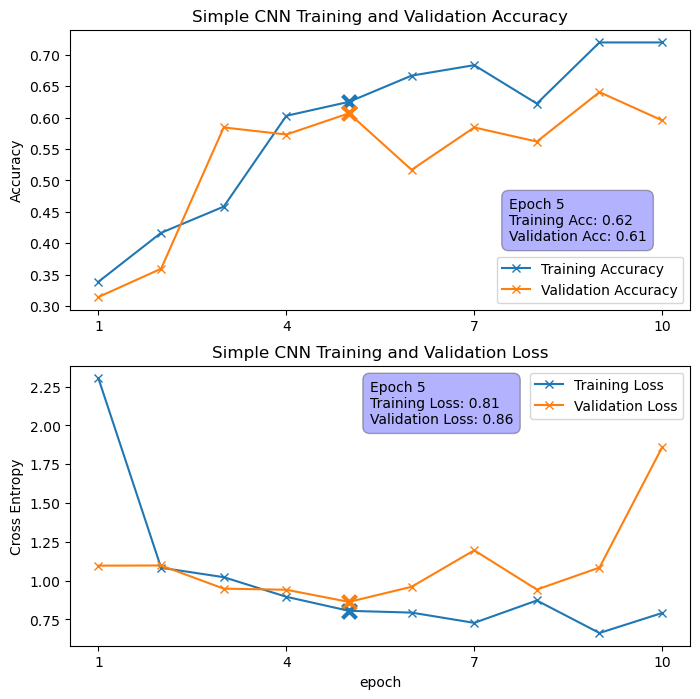

In [206]:
plot_acc_loss('Simple CNN', history, 5, (115, -100), (15, 155))

In [101]:
# Save model
simple_CNN_model.save('simple_CNN_model.keras')

## Simple CNN Evaluation

In [134]:
def get_labels(dataset):
    dataset_labels = []
    for images, labels in dataset:
        dataset_labels.extend(labels.numpy())
    return dataset_labels

def get_prediction(dataset, model):
    predictions = model.predict(dataset)
    y_pred = np.argmax(predictions, axis=1)
    y_pred = list(y_pred)
    return y_pred
    
# True Labels
train_labels = get_labels(train_ds)
val_labels = get_labels(val_ds)

# Predicted Labels
predicted_train_labels = get_prediction(train_ds, simple_CNN_model)
predicted_val_labels = get_prediction(val_ds, simple_CNN_model)

3/3 [==============================] - 0s 58ms/step


In [139]:
# Confirm shape and type
len(train_labels), len(val_labels), len(predicted_train_labels), len(predicted_val_labels), \
type(predicted_train_labels), type(predicted_val_labels)

(360, 89, 360, 89, list, list)

In [140]:
# Create dfs
train_df = pd.DataFrame({'y_train': train_labels, 'y_train_pred': predicted_train_labels})
val_df = pd.DataFrame({'y_val': val_labels, 'y_val_pred': predicted_val_labels})

In [149]:
# Check if both datasets are balanced
print("Train_df:", train_df.y_train.value_counts(), \
      "\n\nValidation_df:", val_df.y_val.value_counts())

Train_df: y_train
0    124
1    118
2    118
Name: count, dtype: int64 

Validation_df: y_val
2    32
1    31
0    26
Name: count, dtype: int64


In [170]:
# Prediction Performance
train_group = train_df.groupby('y_train')['y_train_pred'].value_counts(normalize=True)
val_group = val_df.groupby('y_val')['y_val_pred'].value_counts(normalize=True)
train_accuracy = len(train_df[train_df['y_train'] == train_df['y_train_pred']]) / len(train_df)
val_accuracy = len(val_df[val_df['y_val'] == val_df['y_val_pred']]) / len(val_df)
print("Train\n", train_group)
print("Training Accuracy: ", train_accuracy)
print("\n\nValidation\n", val_group)
print("Validation Accuracy: ", val_accuracy)

Train
 y_train  y_train_pred
0        1               0.451613
         2               0.395161
         0               0.153226
1        2               0.474576
         1               0.398305
         0               0.127119
2        1               0.457627
         2               0.398305
         0               0.144068
Name: proportion, dtype: float64
Training Accuracy:  0.3138888888888889


Validation
 y_val  y_val_pred
0      1             0.423077
       2             0.384615
       0             0.192308
1      1             0.903226
       0             0.064516
       2             0.032258
2      2             0.656250
       1             0.218750
       0             0.125000
Name: proportion, dtype: float64
Validation Accuracy:  0.6067415730337079


The model has a training accuracy of about 31%. Furthermore, it seems that label 0, the church images, are poorly recognized by the model, with only 15% and 19% are being recognized by both datasets, respectively. It tells us that the model is underperforming, and we need to build a more complex model.

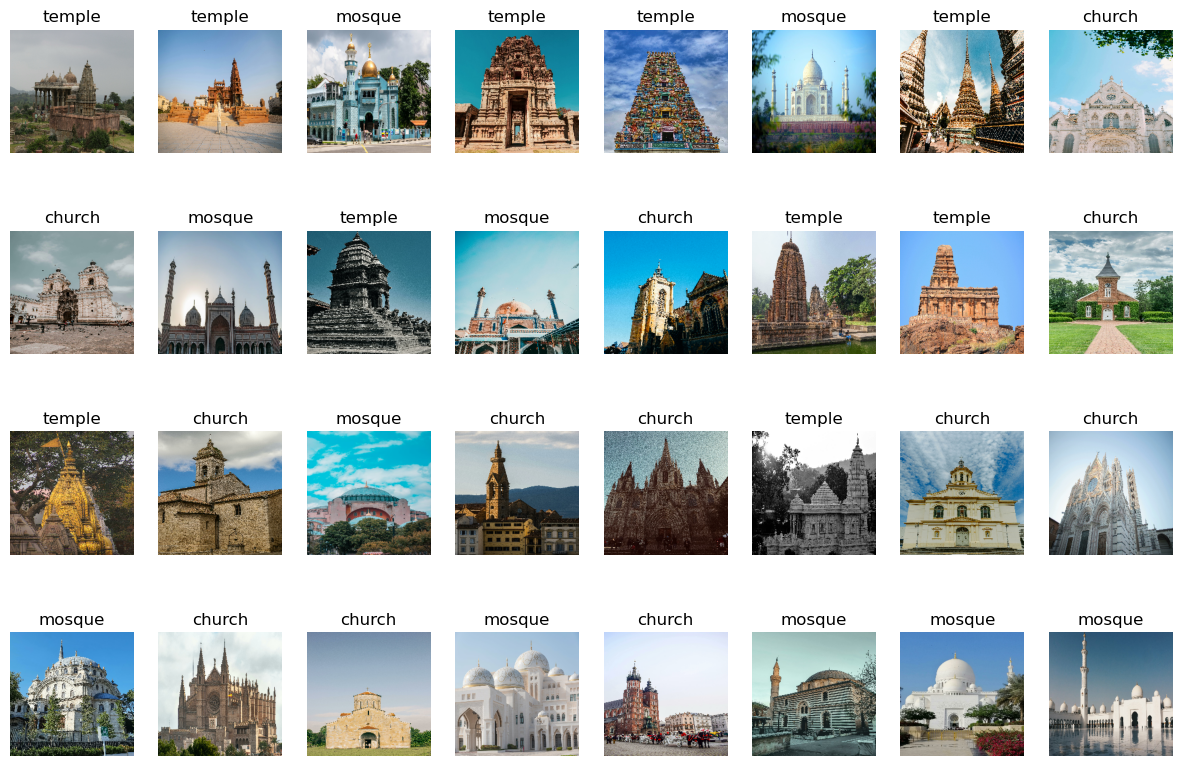

In [173]:
# Image Inspection
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
  for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  break

Unlike mosques and temples, church's shapes tend to vary, this could be the reason why the church images are difficult to be classified by the model.

## A ReligiousBuildingCNN (RBCNN) Model

It is safe to say that increasing the depth of a network is the most straightforward way to improve the performance of one model (Szegedy et al., 2014). However, building a very deep model can run into issues.

1. A very deep model can be overfitting.
2. It is expensive to run a deep network.
3. A degradation problem can occur (He et al., 2015).

Especially in our cass, we are training with only 449 images, the prevention of overfitting is even more crucial for us. Our SimpleCNNModel has experienced overfitting after 5 training epochs. Yet, both training and validation accuracy are about 60% at that point. Inspired ny Resnet, we followed some of the techniques there to mitigate the effect of overfitting.

Let's follow two simple rules to build a CNN model:
1. Implement a residual function every two Conv2D layers.
2. Double the number of filters after a maxpooling layer. 

In [190]:
def resnet_block(inputs, filters, kernel_size, stride):
    # First layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)

    # Skip connection
    if inputs.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(inputs)
    else:
        shortcut = inputs

    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

In [194]:
inputs = Input(shape=(224, 224, 3))
x = Rescaling(1./255)(inputs)
x = Conv2D(32, 7, strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = resnet_block(x, 32, 3, 1)
x = MaxPool2D(2)(x)
x = resnet_block(x, 64, 3, 1)
x = MaxPool2D(2)(x)
x = resnet_block(x, 128, 3, 1)
x = MaxPool2D(2)(x)
x = resnet_block(x, 256, 3, 1)
x = MaxPool2D(2)(x)
x = resnet_block(x, 512, 3, 1)
x = GlobalAveragePooling2D()(x)
outputs = Dense(3, activation='softmax')(x)

RBCNN = tf.keras.Model(inputs, outputs)
RBCNN.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv2d_18 (Conv2D)          (None, 112, 112, 32)         4736      ['rescaling_2[0][0]']         
                                                                                                  
 batch_normalization_11 (Ba  (None, 112, 112, 32)         128       ['conv2d_18[0][0]']           
 tchNormalization)                                                                          

### RBCNN is a 12-layer deep network without any dropout and regularization.

In [197]:
RBCNN.compile(loss='sparse_categorical_crossentropy',
              metrics='accuracy',
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3))
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    mode='auto',
    restore_best_weights=True,
    patience=5,
    start_from_epoch=0
)
RBCNN_history = RBCNN.fit(train_ds,
                    validation_data=val_ds,
                    epochs=100,
                    callbacks=[callback])

Epoch 1/100
12/12 [==============================] - 9s 322ms/step - loss: 1.7480 - accuracy: 0.5056 - val_loss: 8.9755 - val_accuracy: 0.3596
Epoch 2/100
12/12 [==============================] - 2s 173ms/step - loss: 0.9273 - accuracy: 0.5750 - val_loss: 1.6541 - val_accuracy: 0.3483
Epoch 3/100
12/12 [==============================] - 2s 178ms/step - loss: 0.7951 - accuracy: 0.6667 - val_loss: 2.6734 - val_accuracy: 0.3483
Epoch 4/100
12/12 [==============================] - 2s 169ms/step - loss: 0.7673 - accuracy: 0.6667 - val_loss: 2.3128 - val_accuracy: 0.3483
Epoch 5/100
12/12 [==============================] - 2s 169ms/step - loss: 0.7209 - accuracy: 0.7250 - val_loss: 2.4000 - val_accuracy: 0.3483
Epoch 6/100
12/12 [==============================] - 2s 168ms/step - loss: 0.6805 - accuracy: 0.7083 - val_loss: 2.1528 - val_accuracy: 0.3371
Epoch 7/100
12/12 [==============================] - 2s 172ms/step - loss: 0.6262 - accuracy: 0.7472 - val_loss: 1.6321 - val_accuracy: 0.3371

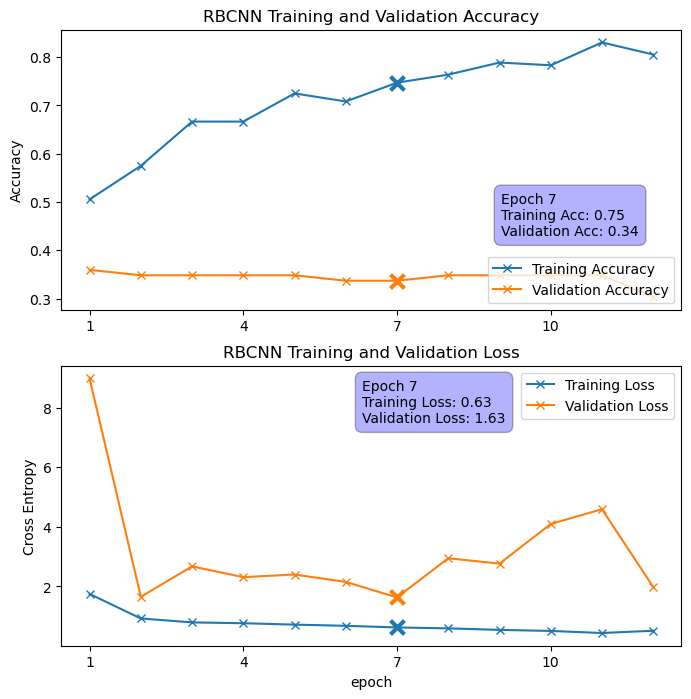

In [221]:
plot_acc_loss('RBCNN', RBCNN_history, 7, (75, -110), (-25, 145))

RBCNN model is clearly overfitting, but we would argue that both the accuracy curves and loss curves are much more linear, unlike the bouncy ones we saw in VGG16 and SimpleCNN. In addition, RBCNN has a 10% improvement on the training set compared to Simple CNN, and it started off with 50% accuracy, when Simple CNN started off with 35% only.

# Image Augmentation

Image augmentation artificially increases the size of the training set by randomly fliping, shifting, and resizing every picture in the training set. Oftentimes, it can reduce overfitting. Let's see if it works on RBCNN!

In [228]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=42),
    tf.keras.layers.RandomRotation(0.2, seed=42),
    tf.keras.layers.RandomZoom(0.2, seed=42),
    tf.keras.layers.RandomBrightness((-0.2, 0.2), seed=42)
])


inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = Rescaling(1./255)(x)
x = Conv2D(32, 7, strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = resnet_block(x, 32, 3, 1)
x = MaxPool2D(2)(x)
x = resnet_block(x, 64, 3, 1)
x = MaxPool2D(2)(x)
x = resnet_block(x, 128, 3, 1)
x = MaxPool2D(2)(x)
x = resnet_block(x, 256, 3, 1)
x = MaxPool2D(2)(x)
x = resnet_block(x, 512, 3, 1)
x = GlobalAveragePooling2D()(x)
outputs = Dense(3, activation='softmax')(x)

RBCNN_v2 = tf.keras.Model(inputs, outputs)
RBCNN_v2.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential_5 (Sequential)   (None, 224, 224, 3)          0         ['input_9[0][0]']             
                                                                                                  
 rescaling_6 (Rescaling)     (None, 224, 224, 3)          0         ['sequential_5[0][0]']        
                                                                                                  
 conv2d_88 (Conv2D)          (None, 112, 112, 32)         4736      ['rescaling_6[0][0]']         
                                                                                            

In [229]:
RBCNN_v2.compile(loss='sparse_categorical_crossentropy',
              metrics='accuracy',
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3))
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    mode='auto',
    restore_best_weights=True,
    patience=5,
    start_from_epoch=0
)
RBCNN_v2_history = RBCNN_v2.fit(train_ds,
                    validation_data=val_ds,
                    epochs=100,
                    callbacks=[callback])

Epoch 1/100
12/12 [==============================] - 6s 343ms/step - loss: 2.3102 - accuracy: 0.3528 - val_loss: 39.9320 - val_accuracy: 0.3483
Epoch 2/100
12/12 [==============================] - 3s 216ms/step - loss: 1.0171 - accuracy: 0.4528 - val_loss: 8.4618 - val_accuracy: 0.3483
Epoch 3/100
12/12 [==============================] - 3s 213ms/step - loss: 0.9456 - accuracy: 0.5083 - val_loss: 2.1143 - val_accuracy: 0.3034
Epoch 4/100
12/12 [==============================] - 3s 211ms/step - loss: 0.9412 - accuracy: 0.5167 - val_loss: 1.6889 - val_accuracy: 0.3483
Epoch 5/100
12/12 [==============================] - 2s 207ms/step - loss: 0.9561 - accuracy: 0.5194 - val_loss: 2.1927 - val_accuracy: 0.3483
Epoch 6/100
12/12 [==============================] - 2s 205ms/step - loss: 0.9383 - accuracy: 0.5333 - val_loss: 2.6921 - val_accuracy: 0.3483
Epoch 7/100
12/12 [==============================] - 2s 205ms/step - loss: 0.9213 - accuracy: 0.5361 - val_loss: 2.6962 - val_accuracy: 0.348

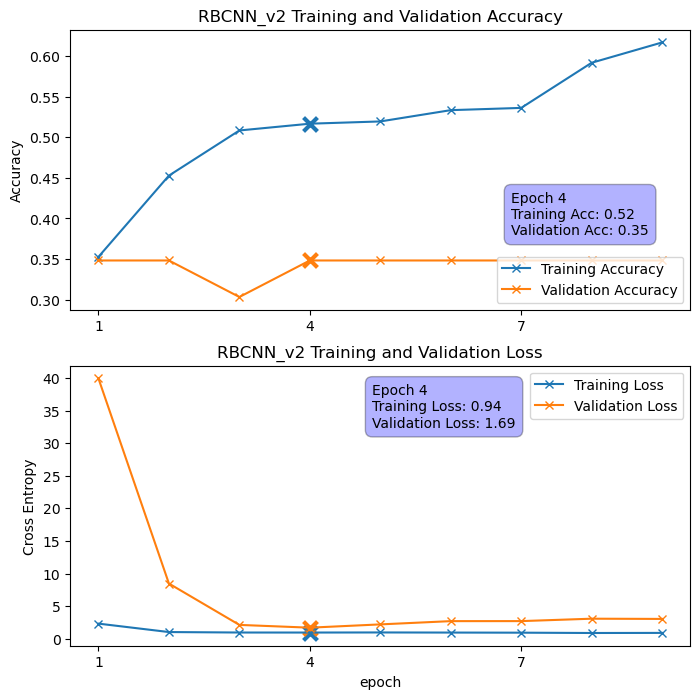

In [241]:
plot_acc_loss('RBCNN_v2', RBCNN_v2_history, 4, (145, -80), (45, 150))

Image augmentation does reduce overfitting to some extend. Unfortunately, the validation accuracy still sits around 35%.

# Initialization

In [246]:
def resnet_block(inputs, filters, kernel_size, stride):
    initializer = tf.keras.initializers.HeNormal()
    # First layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer=initializer)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)

    # Skip connection
    if inputs.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_initializer=initializer)(inputs)
    else:
        shortcut = inputs

    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=42),
    tf.keras.layers.RandomRotation(0.2, seed=42),
    tf.keras.layers.RandomZoom(0.2, seed=42),
    tf.keras.layers.RandomBrightness((-0.2, 0.2), seed=42)
])


inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = Rescaling(1./255)(x)
initializer = tf.keras.initializers.HeNormal()
x = Conv2D(32, 7, strides=2, padding='same', activation='relu', kernel_initializer=initializer)(x)
x = BatchNormalization()(x)
x = resnet_block(x, 32, 3, 1)
x = MaxPool2D(2)(x)
x = resnet_block(x, 64, 3, 1)
x = MaxPool2D(2)(x)
x = resnet_block(x, 128, 3, 1)
x = MaxPool2D(2)(x)
x = resnet_block(x, 256, 3, 1)
x = MaxPool2D(2)(x)
x = resnet_block(x, 512, 3, 1)
x = GlobalAveragePooling2D()(x)
outputs = Dense(3, activation='softmax', kernel_initializer=initializer)(x)

RBCNN_v3 = tf.keras.Model(inputs, outputs)
RBCNN_v3.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential_8 (Sequential)   (None, 224, 224, 3)          0         ['input_12[0][0]']            
                                                                                                  
 rescaling_9 (Rescaling)     (None, 224, 224, 3)          0         ['sequential_8[0][0]']        
                                                                                                  
 conv2d_118 (Conv2D)         (None, 112, 112, 32)         4736      ['rescaling_9[0][0]']         
                                                                                            

In [247]:
RBCNN_v3.compile(loss='sparse_categorical_crossentropy',
              metrics='accuracy',
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3))
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    mode='auto',
    restore_best_weights=True,
    patience=5,
    start_from_epoch=0
)
RBCNN_v3_history = RBCNN_v3.fit(train_ds,
                    validation_data=val_ds,
                    epochs=100,
                    callbacks=[callback])

Epoch 1/100
12/12 [==============================] - 5s 327ms/step - loss: 4.4691 - accuracy: 0.4278 - val_loss: 81.6739 - val_accuracy: 0.3596
Epoch 2/100
12/12 [==============================] - 3s 215ms/step - loss: 1.4613 - accuracy: 0.5056 - val_loss: 34.4751 - val_accuracy: 0.2921
Epoch 3/100
12/12 [==============================] - 3s 213ms/step - loss: 0.9927 - accuracy: 0.5472 - val_loss: 11.4150 - val_accuracy: 0.2921
Epoch 4/100
12/12 [==============================] - 3s 209ms/step - loss: 0.9774 - accuracy: 0.5861 - val_loss: 4.4870 - val_accuracy: 0.2921
Epoch 5/100
12/12 [==============================] - 2s 206ms/step - loss: 0.9181 - accuracy: 0.5639 - val_loss: 1.6878 - val_accuracy: 0.3371
Epoch 6/100
12/12 [==============================] - 3s 209ms/step - loss: 0.8858 - accuracy: 0.6111 - val_loss: 1.3723 - val_accuracy: 0.3820
Epoch 7/100
12/12 [==============================] - 2s 206ms/step - loss: 0.9150 - accuracy: 0.5778 - val_loss: 1.0295 - val_accuracy: 0.4

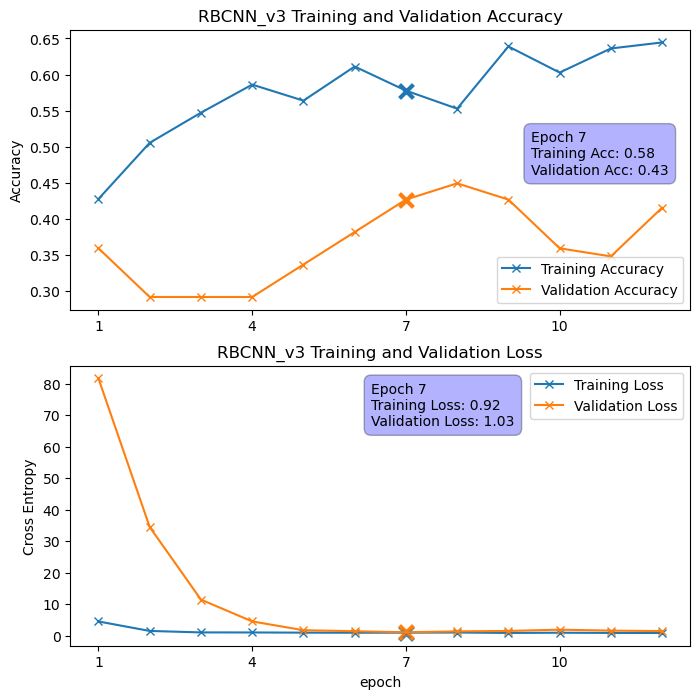

In [255]:
plot_acc_loss('RBCNN_v3', RBCNN_v3_history, 7, (90, -60), (-25, 150))

After implementing weight initialization across all layers with weights, the accuracy of the validation set goes up 10%.  

# Downsample each time dimension increases

In [306]:
def resnet_block(inputs, filters, kernel_size, downsample=True):
    initializer = tf.keras.initializers.HeNormal()
    stride = 2 if downsample else 1
    # First layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer=initializer)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second layer
    x = Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)

    # Skip connection
    if inputs.shape[-1] != filters or downsample:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_initializer=initializer)(inputs)
    else:
        shortcut = inputs

    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=42),
    tf.keras.layers.RandomRotation(0.2, seed=42),
    tf.keras.layers.RandomZoom(0.2, seed=42),
    tf.keras.layers.RandomBrightness((-0.2, 0.2), seed=42)
])


inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = Rescaling(1./255)(x)
initializer = tf.keras.initializers.HeNormal()
x = Conv2D(32, 7, strides=2, padding='same', activation='relu', kernel_initializer=initializer)(x)
x = BatchNormalization()(x)
x = resnet_block(x, 32, 3, downsample=False)
x = MaxPool2D(2)(x)
x = resnet_block(x, 64, 3, downsample=True)
x = MaxPool2D(2)(x)
x = resnet_block(x, 128, 3, downsample=True)
x = MaxPool2D(2)(x)
x = resnet_block(x, 256, 3, downsample=True)
x = MaxPool2D(2)(x)
x = resnet_block(x, 512, 3, downsample=True)
x = GlobalAveragePooling2D()(x)
outputs = Dense(3, activation='softmax', kernel_initializer=initializer)(x)

RBCNN_v4 = tf.keras.Model(inputs, outputs)

RBCNN_v4.compile(loss='sparse_categorical_crossentropy',
              metrics='accuracy',
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3))
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    mode='auto',
    restore_best_weights=True,
    patience=5,
    start_from_epoch=0
)
RBCNN_v4_history = RBCNN_v4.fit(train_ds,
                    validation_data=val_ds,
                    epochs=100,
                    callbacks=[callback])

Epoch 1/100


/Users/edward/miniforge3/envs/dl/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 [==============================] - 7s 398ms/step - loss: 5.5244 - accuracy: 0.4306 - val_loss: 32.0547 - val_accuracy: 0.3596
Epoch 2/100
12/12 [==============================] - 2s 162ms/step - loss: 2.2742 - accuracy: 0.4694 - val_loss: 18.2459 - val_accuracy: 0.3596
Epoch 3/100
12/12 [==============================] - 2s 157ms/step - loss: 1.2940 - accuracy: 0.5667 - val_loss: 16.5570 - val_accuracy: 0.3596
Epoch 4/100
12/12 [==============================] - 2s 156ms/step - loss: 1.3136 - accuracy: 0.5194 - val_loss: 6.1688 - val_accuracy: 0.3146
Epoch 5/100
12/12 [==============================] - 2s 158ms/step - loss: 1.0886 - accuracy: 0.5583 - val_loss: 5.1409 - val_accuracy: 0.3258
Epoch 6/100
12/12 [==============================] - 2s 142ms/step - loss: 1.0100 - accuracy: 0.5889 - val_loss: 2.3581 - val_accuracy: 0.3933
Epoch 7/100
12/12 [==============================] - 2s 144ms/step - loss: 0.9552 - accuracy: 0.5889 - val_loss: 2.0304 - val_accuracy: 0.4045
Epoch 8/

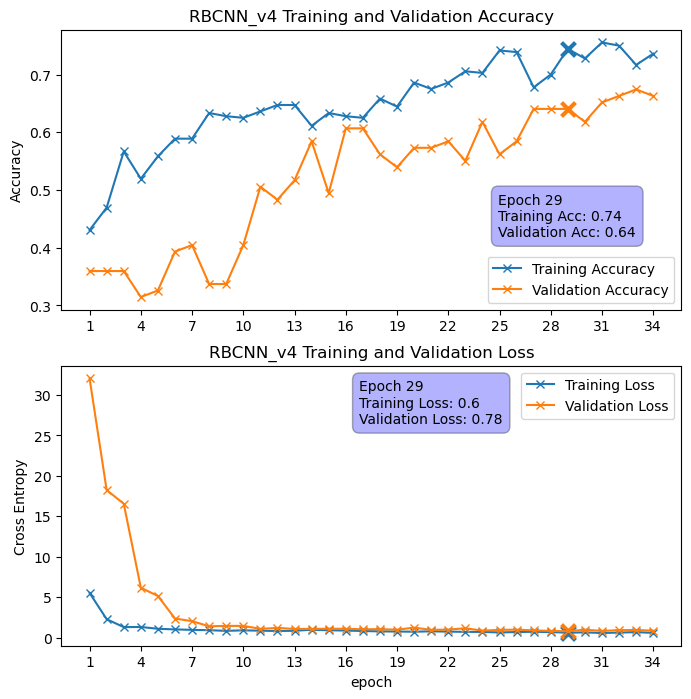

In [322]:
plot_acc_loss('RBCNN_v4', RBCNN_v4_history, 29, (-50, -135), (-150, 150))

In [384]:
# save RBCNN_v4
RBCNN_v4.save('RBCNN_v4.keras')

With downsampling, we now have 61% accuracy on the validation set.

In [307]:
# True Labels
train_labels = get_labels(train_ds)
val_labels = get_labels(val_ds)

# Predicted Labels
predicted_train_labels_v4 = get_prediction(train_ds, RBCNN_v4)
predicted_val_labels_v4 = get_prediction(val_ds, RBCNN_v4)

3/3 [==============================] - 0s 179ms/step


In [314]:
# Create dfs
train_df_v4 = pd.DataFrame({'y_train': train_labels, 'y_train_pred_v4': predicted_train_labels_v4})
val_df_v4 = pd.DataFrame({'y_val': val_labels, 'y_val_pred_v4': predicted_val_labels_v4})

# Prediction Performance
train_group_v4 = train_df_v4.groupby('y_train')['y_train_pred_v4'].value_counts(normalize=True)
val_group_v4 = val_df_v4.groupby('y_val')['y_val_pred_v4'].value_counts(normalize=True)
train_accuracy_v4 = len(train_df_v4[train_df_v4['y_train'] == train_df_v4['y_train_pred_v4']]) / len(train_df_v4)
val_accuracy_v4 = len(val_df_v4[val_df_v4['y_val'] == val_df_v4['y_val_pred_v4']]) / len(val_df_v4)
print("Train\n", train_group_v4)
print("Training Accuracy: ", train_accuracy_v4)
print("\n\nValidation\n", val_group_v4)
print("Validation Accuracy: ", val_accuracy_v4)

Train
 y_train  y_train_pred_v4
0        0                  0.516129
         1                  0.298387
         2                  0.185484
1        0                  0.500000
         1                  0.271186
         2                  0.228814
2        0                  0.415254
         1                  0.322034
         2                  0.262712
Name: proportion, dtype: float64
Training Accuracy:  0.3527777777777778


Validation
 y_val  y_val_pred_v4
0      0                0.538462
       2                0.269231
       1                0.192308
1      1                0.709677
       0                0.290323
2      2                0.656250
       0                0.250000
       1                0.093750
Name: proportion, dtype: float64
Validation Accuracy:  0.6404494382022472


Label 0 remains the hardest to recognize. Let's take it out and only train with two labels.

# Training without Label 0

In [366]:
train_ds_two_labels, val_ds_two_labels = tf.keras.utils.image_dataset_from_directory(
  'image_data_copy',
  labels='inferred',
  label_mode='int',
  validation_split=0.15,
  subset="both",
  seed=42,
  image_size=(224, 224),
  batch_size=32)

Found 299 files belonging to 2 classes.
Using 255 files for training.
Using 44 files for validation.


In [367]:
# Verify class name
train_ds_two_labels.class_names, val_ds_two_labels.class_names

(['mosque', 'temple'], ['mosque', 'temple'])

In [368]:
# Speed up training time (optional)
AUTOTUNE = tf.data.AUTOTUNE

train_ds_two_labels = train_ds_two_labels.cache().shuffle(300).prefetch(buffer_size=AUTOTUNE)
val_ds_two_labels = val_ds_two_labels.cache().prefetch(buffer_size=AUTOTUNE)

In [369]:
def resnet_block(inputs, filters, kernel_size, downsample=True):
    initializer = tf.keras.initializers.HeNormal()
    stride = 2 if downsample else 1
    # First layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer=initializer)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second layer
    x = Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)

    # Skip connection
    if inputs.shape[-1] != filters or downsample:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_initializer=initializer)(inputs)
    else:
        shortcut = inputs

    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=42),
    tf.keras.layers.RandomRotation(0.2, seed=42),
    tf.keras.layers.RandomZoom(0.2, seed=42),
    tf.keras.layers.RandomBrightness((-0.2, 0.2), seed=42)
])


inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = Rescaling(1./255)(x)
initializer = tf.keras.initializers.HeNormal()
x = Conv2D(32, 7, strides=2, padding='same', activation='relu', kernel_initializer=initializer)(x)
x = BatchNormalization()(x)
x = resnet_block(x, 32, 3, downsample=False)
x = MaxPool2D(2)(x)
x = resnet_block(x, 64, 3, downsample=True)
x = MaxPool2D(2)(x)
x = resnet_block(x, 128, 3, downsample=True)
x = MaxPool2D(2)(x)
x = resnet_block(x, 256, 3, downsample=True)
x = MaxPool2D(2)(x)
x = resnet_block(x, 512, 3, downsample=True)
x = GlobalAveragePooling2D()(x)
outputs = Dense(3, activation='softmax', kernel_initializer=initializer)(x)

RBCNN_v5 = tf.keras.Model(inputs, outputs)

RBCNN_v5.compile(loss='sparse_categorical_crossentropy',
              metrics='accuracy',
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3))
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    mode='auto',
    restore_best_weights=True,
    patience=5,
    start_from_epoch=0
)
RBCNN_v5_history = RBCNN_v5.fit(train_ds_two_labels,
                    validation_data=val_ds_two_labels,
                    epochs=100,
                    callbacks=[callback])

Epoch 1/100


/Users/edward/miniforge3/envs/dl/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


8/8 [==============================] - 16s 1s/step - loss: 4.8020 - accuracy: 0.6314 - val_loss: 33.1817 - val_accuracy: 0.5455
Epoch 2/100
8/8 [==============================] - 2s 238ms/step - loss: 1.8222 - accuracy: 0.6784 - val_loss: 28.3064 - val_accuracy: 0.5455
Epoch 3/100
8/8 [==============================] - 1s 189ms/step - loss: 1.0487 - accuracy: 0.7451 - val_loss: 27.6870 - val_accuracy: 0.5455
Epoch 4/100
8/8 [==============================] - 2s 196ms/step - loss: 0.7305 - accuracy: 0.7412 - val_loss: 15.7183 - val_accuracy: 0.5455
Epoch 5/100
8/8 [==============================] - 1s 151ms/step - loss: 0.5870 - accuracy: 0.7686 - val_loss: 7.1205 - val_accuracy: 0.5455
Epoch 6/100
8/8 [==============================] - 1s 161ms/step - loss: 0.6200 - accuracy: 0.7843 - val_loss: 6.6958 - val_accuracy: 0.5455
Epoch 7/100
8/8 [==============================] - 1s 166ms/step - loss: 0.5128 - accuracy: 0.7882 - val_loss: 2.5592 - val_accuracy: 0.5455
Epoch 8/100
8/8 [======

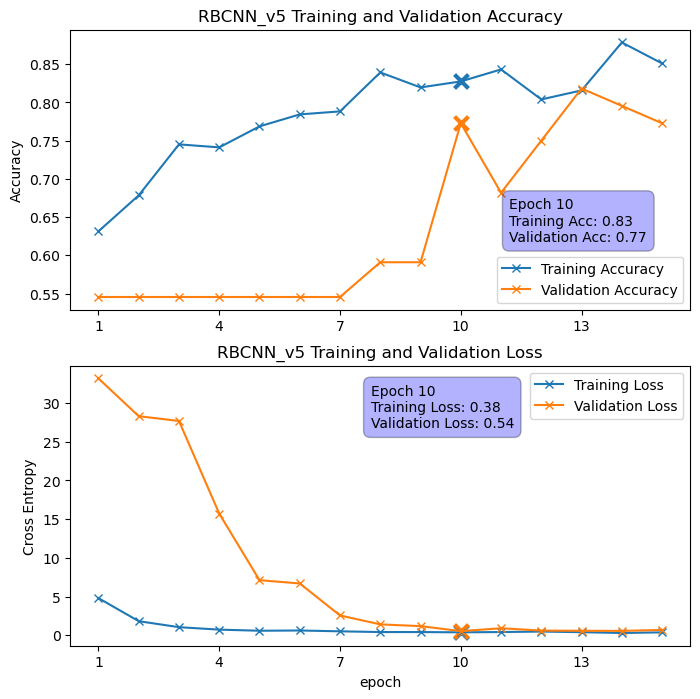

In [379]:
plot_acc_loss('RBCNN_v5', RBCNN_v5_history, 10, (35, -115), (-65, 145))

In [371]:
# True Labels
train_two_labels = get_labels(train_ds_two_labels)
val_two_labels = get_labels(val_ds_two_labels)

# Predicted Labels
predicted_train_labels_v5 = get_prediction(train_ds_two_labels, RBCNN_v5)
predicted_val_labels_v5 = get_prediction(val_ds_two_labels, RBCNN_v5)

2/2 [==============================] - 0s 385ms/step


In [372]:
# Create dfs
train_df_v5 = pd.DataFrame({'y_train': train_two_labels, 'y_train_pred_v5': predicted_train_labels_v5})
val_df_v5 = pd.DataFrame({'y_val': val_two_labels, 'y_val_pred_v5': predicted_val_labels_v5})

# Prediction Performance
train_group_v5 = train_df_v5.groupby('y_train')['y_train_pred_v5'].value_counts(normalize=True)
val_group_v5 = val_df_v5.groupby('y_val')['y_val_pred_v5'].value_counts(normalize=True)
train_accuracy_v5 = len(train_df_v5[train_df_v5['y_train'] == train_df_v5['y_train_pred_v5']]) / len(train_df_v5)
val_accuracy_v5 = len(val_df_v5[val_df_v5['y_val'] == val_df_v5['y_val_pred_v5']]) / len(val_df_v5)
print("Train\n", train_group_v5)
print("Training Accuracy: ", train_accuracy_v5)
print("\n\nValidation\n", val_group_v5)
print("Validation Accuracy: ", val_accuracy_v5)

Train
 y_train  y_train_pred_v5
0        0                  0.651163
         1                  0.348837
1        1                  0.555556
         0                  0.444444
Name: proportion, dtype: float64
Training Accuracy:  0.6039215686274509


Validation
 y_val  y_val_pred_v5
0      0                0.750000
       1                0.250000
1      1                0.791667
       0                0.208333
Name: proportion, dtype: float64
Validation Accuracy:  0.7727272727272727


The model with two labels seems to perform a lot better in the training set. The acurracy is only about 60%. Therefore, the model is still not competent enough to distinguish religious buildings. Noted that we are training with around 100 images for each class. From RBCNN to RBCNN_v4, we applied different methods to prevent overfitting, and the results look promising. With more training images available, we expect the model could perform better.

# Additional Images

We have added around 50 items each to train RBCNN_v4.

In [434]:
add_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'new_image_data',
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    shuffle=True,
    seed=42
)

Found 148 files belonging to 3 classes.


In [435]:
add_train_ds.class_names

['church', 'mosque', 'temple']

In [444]:
combined_train_ds = train_ds.concatenate(add_train_ds)

In [446]:
# Shuffle and Prefetch
AUTOTUNE = tf.data.AUTOTUNE

combined_train_ds = combined_train_ds.cache().shuffle(250).prefetch(buffer_size=AUTOTUNE)

In [452]:
def resnet_block(inputs, filters, kernel_size, downsample=True):
    stride = 2 if downsample else 1
    # First layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second layer
    x = Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(x)
    x = BatchNormalization()(x)

    # Skip connection
    if inputs.shape[-1] != filters or downsample:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    else:
        shortcut = inputs

    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=42),
    tf.keras.layers.RandomRotation(0.2, seed=42),
    tf.keras.layers.RandomZoom(0.2, seed=42),
    tf.keras.layers.RandomBrightness((-0.2, 0.2), seed=42)
])


inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = Rescaling(1./255)(x)
initializer = tf.keras.initializers.HeNormal()
x = Conv2D(32, 7, strides=2, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(x)
x = BatchNormalization()(x)
x = resnet_block(x, 32, 3, downsample=False)
x = MaxPool2D(2)(x)
x = resnet_block(x, 64, 3, downsample=True)
x = MaxPool2D(2)(x)
x = resnet_block(x, 128, 3, downsample=True)
x = MaxPool2D(2)(x)
x = resnet_block(x, 256, 3, downsample=True)
x = MaxPool2D(2)(x)
x = resnet_block(x, 512, 3, downsample=True)
x = GlobalAveragePooling2D()(x)
outputs = Dense(3, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal())(x)

RBCNN_v4_added = tf.keras.Model(inputs, outputs)

RBCNN_v4_added.compile(loss='sparse_categorical_crossentropy',
              metrics='accuracy',
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3))
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    mode='auto',
    restore_best_weights=True,
    patience=8,
    start_from_epoch=0
)
RBCNN_v4_added_history = RBCNN_v4_added.fit(combined_train_ds,
                    validation_data=val_ds,
                    epochs=100,
                    callbacks=[callback])

Epoch 1/100
17/17 [==============================] - 12s 587ms/step - loss: 4.4555 - accuracy: 0.4094 - val_loss: 2.1511 - val_accuracy: 0.3483
Epoch 2/100
17/17 [==============================] - 5s 302ms/step - loss: 2.1780 - accuracy: 0.4173 - val_loss: 4.5934 - val_accuracy: 0.3596
Epoch 3/100
17/17 [==============================] - 5s 293ms/step - loss: 1.4680 - accuracy: 0.4291 - val_loss: 2.3732 - val_accuracy: 0.3034
Epoch 4/100
17/17 [==============================] - 5s 304ms/step - loss: 1.1176 - accuracy: 0.5059 - val_loss: 2.0784 - val_accuracy: 0.3146
Epoch 5/100
17/17 [==============================] - 5s 292ms/step - loss: 1.1305 - accuracy: 0.4862 - val_loss: 1.1522 - val_accuracy: 0.4157
Epoch 6/100
17/17 [==============================] - 5s 281ms/step - loss: 1.0658 - accuracy: 0.5197 - val_loss: 1.4496 - val_accuracy: 0.3820
Epoch 7/100
17/17 [==============================] - 5s 274ms/step - loss: 1.0840 - accuracy: 0.5197 - val_loss: 1.2301 - val_accuracy: 0.471

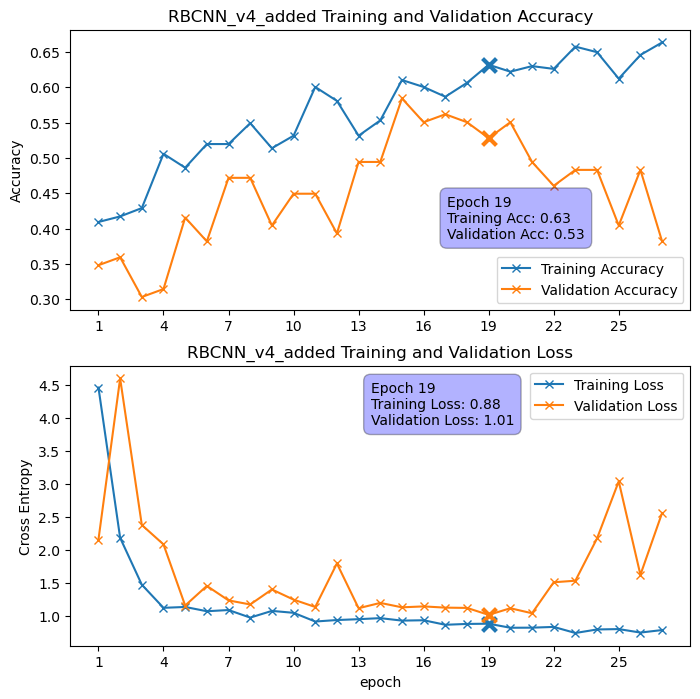

In [456]:
plot_acc_loss('RBCNN_v4_added', RBCNN_v4_added_history, 19, (-30, -125), (-85, 155))

In [454]:
# True Labels
train_labels = get_labels(train_ds)
val_labels = get_labels(val_ds)

# Predicted Labels
predicted_train_labels_v4_added = get_prediction(train_ds, RBCNN_v4_added)
predicted_val_labels_v4_added = get_prediction(val_ds, RBCNN_v4_added)

# Create dfs
train_df_v4_added = pd.DataFrame({'y_train': train_labels, 'y_train_pred_v4_added': predicted_train_labels_v4_added})
val_df_v4_added = pd.DataFrame({'y_val': val_labels, 'y_val_pred_v4_added': predicted_val_labels_v4_added})

# Prediction Performance
train_group_v4_added = train_df_v4_added.groupby('y_train')['y_train_pred_v4_added'].value_counts(normalize=True)
val_group_v4_added = val_df_v4_added.groupby('y_val')['y_val_pred_v4_added'].value_counts(normalize=True)
train_accuracy_v4_added = len(train_df_v4_added[train_df_v4_added['y_train'] == train_df_v4_added['y_train_pred_v4_added']]) / len(train_df_v4_added)
val_accuracy_v4_added = len(val_df_v4_added[val_df_v4_added['y_val'] == val_df_v4_added['y_val_pred_v4_added']]) / len(val_df_v4_added)
print("Train\n", train_group_v4_added)
print("Training Accuracy: ", train_accuracy_v4_added)
print("\n\nValidation\n", val_group_v4_added)
print("Validation Accuracy: ", val_accuracy_v4_added)

3/3 [==============================] - 2s 867ms/step
Train
 y_train  y_train_pred_v4_added
0        1                        0.338710
         0                        0.330645
         2                        0.330645
1        2                        0.364407
         1                        0.347458
         0                        0.288136
2        1                        0.372881
         0                        0.330508
         2                        0.296610
Name: proportion, dtype: float64
Training Accuracy:  0.325


Validation
 y_val  y_val_pred_v4_added
0      1                      0.346154
       2                      0.346154
       0                      0.307692
1      1                      0.677419
       0                      0.290323
       2                      0.032258
2      2                      0.562500
       0                      0.312500
       1                      0.125000
Name: proportion, dtype: float64
Validation Accuracy:  0.52808988764044

Both training and validation accuracy were slightly lower than RBCNN_v4, despites having roughly 50 more images per class to train. We concluded 50 more images were not enough to trian a better model. It still remains a challege for us to gather more images.